# ABC calibration of $I_\text{Kur}$ in Nygren model to unified dataset.

Note the term $I_\text{sus}$ for sustained outward Potassium current is used throughout the notebook.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Wang1993]
 - Activation time constant [Wang1993]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Firek1995]
 - Inactivation time constant [Nygren1998]
 - Recovery time constant [Nygren1998]

In [8]:
from experiments.isus_wang import (wang_act_and_kin)
from experiments.isus_courtemanche import (courtemanche_deact)

In [9]:
modelfile = 'models/nygren_isus.mmt'

Plot steady-state and time constant functions of original model

In [10]:
from ionchannelABC.visualization import plot_variables

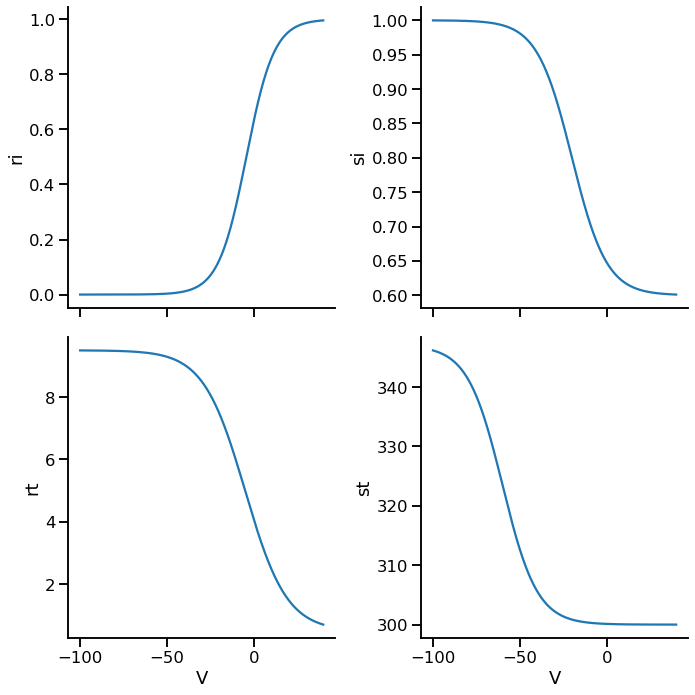

In [11]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

nyg_par_map = {'ri': 'isus.r_inf',
            'si': 'isus.s_inf',
            'rt': 'isus.tau_r',
            'st': 'isus.tau_s'}

f, ax = plot_variables(V, nyg_par_map, modelfile, figshape=(2,2))

# Activation gate ($r$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [12]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin,
                                                courtemanche_deact)

In [13]:
assert len(observations)==len(summary_statistics(model({})))

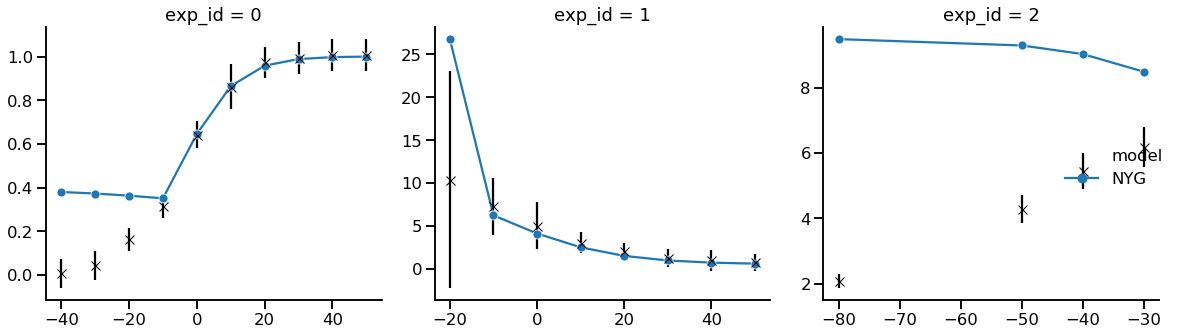

In [14]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     courtemanche_deact)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [15]:
limits = {'isus.p1': (-100, 100),
          'isus.p2': (1e-7, 50),
          'log_isus.p3': (-5, 0),
          'isus.p4': (-100, 100),
          'isus.p5': (1e-7, 50),
          'log_isus.p6': (-6, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_isus_rgate_unified.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9291864600781273, '1': 0.9289966364907764, '2': 1.1348736050966737, '3': 1.1351568985577465, '4': 1.0214372272287315, '5': 0.6011154706704985, '6': 0.8515802501165396, '7': 0.8517397519427469, '8': 0.8517397519427501, '9': 0.8515802501165396, '10': 0.06311509727573296, '11': 0.2414626843624501, '12': 0.29232255580339506, '13': 0.6534268894428844, '14': 0.8550117212573514, '15': 0.7403514554934645, '16': 0.65342688944288, '17': 0.7929901456221022, '18': 3.0675207501965804, '19': 2.2089529135079435, '20': 1.7402522202557973, '21': 1.5337603750982902}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-30 11:21:22.650947, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [16]:
history = History('sqlite:///results/nygren/isus/unified/nygren_isus_rgate_unified.db')

In [17]:
df, w = history.get_distribution()

In [18]:
df.describe()

name,isus.p1,isus.p2,isus.p4,isus.p5,log_isus.p3,log_isus.p6
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.029179,4.306471,-19.031168,5.107270,-2.552966,-3.072768
std,0.015812,0.009054,0.137341,0.088877,0.002136,0.007005
min,1.987024,4.279309,-19.459954,4.823907,-2.558937,-3.097682
25%,2.019115,4.300300,-19.120728,5.045922,-2.554499,-3.077573
50%,2.030524,4.305298,-19.030817,5.105392,-2.553019,-3.072672
75%,2.040124,4.310441,-18.937601,5.169344,-2.551466,-3.067885
max,2.072857,4.325692,-18.616497,5.413097,-2.545471,-3.052737


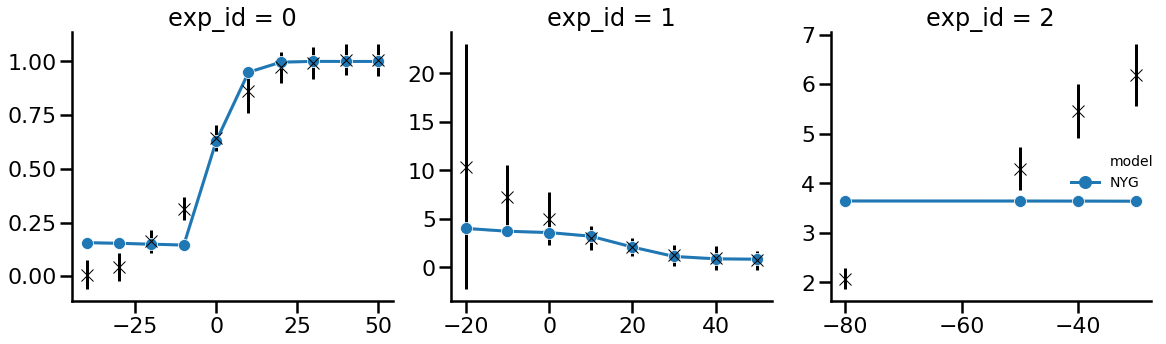

In [19]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                    courtemanche_deact,
                     df=df, w=w)
plt.tight_layout()

In [20]:
import pandas as pd
N = 100
nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

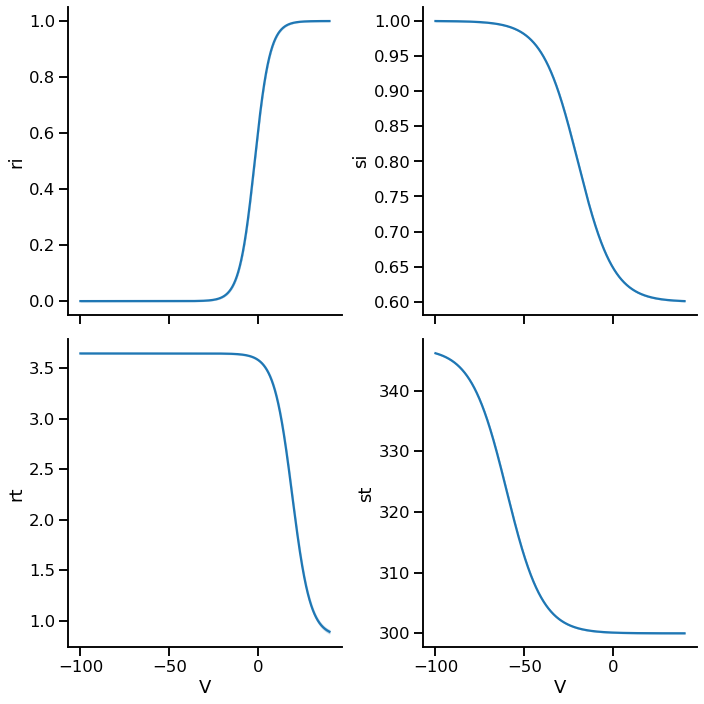

In [21]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_isus.mmt', 
                       [nyg_par_samples],
                       figshape=(2,2))

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

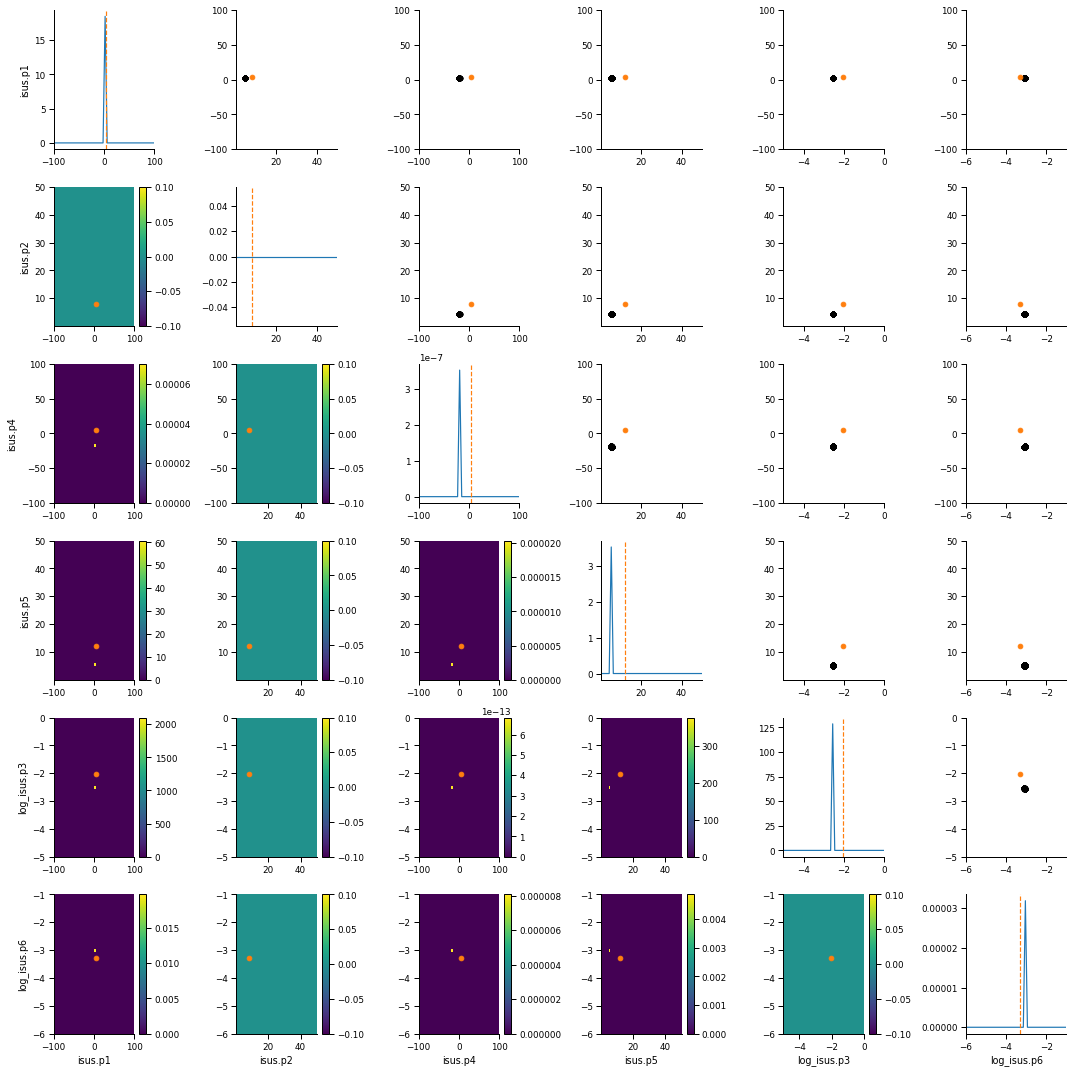

In [25]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()